In this notebook, we will finally create predictive features using the logs we cleaned on notebook 2.2. 

Our focus will be to obtain the Temporal Data. We consider this to be the number of clicks in a given percentile.

#### 1. Importing the relevant packages, setting global variables and importing the relevant files

In [1]:
#import libs
import pandas as pd
import numpy as np
from pandas.tseries.offsets import *

#viz related tools
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns

#tqdm to monitor progress
from tqdm.notebook import tqdm, trange
tqdm.pandas(desc="Progress")

#time related features
from datetime import timedelta
from copy import copy, deepcopy

#starting with other tools
sns.set()

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#to save
import xlsxwriter

In [2]:
#global variables that may come in handy
#course threshold sets the % duration that will be considered (1 = 100%)
duration_threshold = [0.1, 0.25, 0.33, 0.5, 1]

#colors for vizualizations
nova_ims_colors = ['#BFD72F', '#5C666C']

#standard color for student aggregates
student_color = '#474838'

#standard color for course aggragates
course_color = '#1B3D2F'

#standard continuous colormap
standard_cmap = 'viridis_r'

#Function designed to deal with multiindex and flatten it
def flattenHierarchicalCol(col,sep = '_'):
    '''converts multiindex columns into single index columns while retaining the hierarchical components'''
    if not type(col) is tuple:
        return col
    else:
        new_col = ''
        for leveli,level in enumerate(col):
            if not level == '':
                if not leveli == 0:
                    new_col += sep
                new_col += level
        return new_col

In [3]:
#loading student log data 
student_logs = pd.read_csv('../Data/Modeling Stage/NovaIMS_cleaned_logs.csv',
                           dtype = {
                                   'cd_curso': float,
                                   'userid': float,
                                   'courseid': float,
                                   },
                                   parse_dates = ['time']).drop('Unnamed: 0', axis = 1) #logs

#converting to object
student_logs['userid'], student_logs['cd_curso'], student_logs['courseid'] = student_logs['userid'].astype(object), student_logs['cd_curso'].astype(object), student_logs['courseid'].astype(object)

#other tables with support information
support_table = pd.read_csv('../Data/Nova_IMS_support_table.csv',
                             dtype = {
                                 'cd_curso' : float,
                                 'courseid' : float,
                                 'userid' : float,
                                 'assign_id': float,
                             }, parse_dates = ['startdate', 'end_date']).drop('Unnamed: 0', axis = 1)

#converting to object
support_table['userid'], support_table['cd_curso'], support_table['courseid'], support_table['assign_id'] = support_table['userid'].astype(object), support_table['cd_curso'].astype(object), support_table['courseid'].astype(object), support_table['assign_id'].astype(object)

#save tables 
class_list = pd.read_csv('../Data/Modeling Stage/NovaIMS_class_duration.csv', 
                         dtype = {
                                   'cd_curso': float,
                                   'courseid': float,                                   
                                   },
                        parse_dates = ['Start Date','End Date', 'cuttoff_point']).rename(columns = {'cuttoff_point' : 'Week before start'})

#converting to object
class_list['cd_curso'], class_list['courseid'] = class_list['cd_curso'].astype(object), class_list['courseid'].astype(object)

#targets tables 
targets_table = pd.read_csv('../Data/Modeling Stage/Nova_IMS_targets_table.csv',
                           dtype = {
                                   'cd_curso': float,
                                   'userid': float,
                                   'courseid': float,
                                   },).drop('Unnamed: 0', axis = 1)

#converting to float
targets_table['userid'], targets_table['courseid'] = targets_table['userid'].astype(object), targets_table['courseid'].astype(object)

We'll start with the general verification of the different datasets we've imported. 

**Starting with the targets table, which includes all valid student-course logs with Final-Grade.**

In [4]:
#get info
targets_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15289 entries, 0 to 15288
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cd_curso      15289 non-null  float64
 1   nm_curso_pt   15289 non-null  object 
 2   courseid      15289 non-null  object 
 3   ds_discip_pt  15289 non-null  object 
 4   semestre      15289 non-null  object 
 5   userid        15289 non-null  object 
 6   final_mark    15289 non-null  float64
 7   exam_mark     15289 non-null  float64
dtypes: float64(3), object(5)
memory usage: 955.7+ KB


In [5]:
targets_table.describe(include = 'all', datetime_is_numeric = True)

,cd_curso,nm_curso_pt,courseid,ds_discip_pt,semestre,userid,final_mark,exam_mark
count,15289.000000,15289,15289.0,15289,15289,15289.0,15289.000000,15289.000000
unique,NaN,28,251.0,239,6,2305.0,NaN,NaN
top,NaN,Mestrado em Gestão de Informação,200086.0,Business Process Management,S1,3248.0,NaN,NaN
freq,NaN,3338,339.0,356,6216,17.0,NaN,NaN
mean,7284.332330,NaN,NaN,NaN,NaN,NaN,14.911178,14.544688
std,2158.531359,NaN,NaN,NaN,NaN,NaN,3.752871,4.075090
min,859.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
25%,4973.000000,NaN,NaN,NaN,NaN,NaN,14.000000,13.000000
50%,8183.000000,NaN,NaN,NaN,NaN,NaN,16.000000,16.000000
75%,9155.000000,NaN,NaN,NaN,NaN,NaN,17.000000,17.000000


In [6]:
targets_table

,cd_curso,nm_curso_pt,courseid,ds_discip_pt,semestre,userid,final_mark,exam_mark
0,8259.0,Licenciatura em Sistemas e Tecnologias de Info...,100001.0,Álgebra Linear,S1,1544.0,4.0,4.0
1,8259.0,Licenciatura em Sistemas e Tecnologias de Info...,100001.0,Álgebra Linear,S1,1556.0,6.0,9.0
2,9155.0,Licenciatura em Gestão de Informação,100001.0,Álgebra Linear,S1,1564.0,10.0,9.0
3,8259.0,Licenciatura em Sistemas e Tecnologias de Info...,100001.0,Álgebra Linear,S1,3146.0,15.0,15.0
4,9155.0,Licenciatura em Gestão de Informação,100001.0,Álgebra Linear,S1,3178.0,11.0,9.0
...,...,...,...,...,...,...,...,...
15284,4969.0,Pós-Graduação em Digital Enterprise Management,400094.0,Big Data Analytics for Business,T4,7230.0,9.0,9.0
15285,4969.0,Pós-Graduação em Digital Enterprise Management,400094.0,Big Data Analytics for Business,T4,7242.0,14.0,14.0
15286,4969.0,Pós-Graduação em Digital Enterprise Management,400094.0,Big Data Analytics for Business,T4,7243.0,16.0,16.0
15287,4969.0,Pós-Graduação em Digital Enterprise Management,400094.0,Big Data Analytics for Business,T4,7248.0,15.0,15.0


Then, we repeat the same for the list of courses and their respective start and end dates. We know that the number of students attending each course is the number found in the logs. We will need to make further cuts 

In [7]:
class_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   cd_curso              630 non-null    object        
 1   semestre              630 non-null    object        
 2   courseid              630 non-null    object        
 3   Users per course      630 non-null    int64         
 4   Start Date            630 non-null    datetime64[ns]
 5   End Date              630 non-null    datetime64[ns]
 6   Course duration days  630 non-null    float64       
 7   Week before start     630 non-null    datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(1), object(3)
memory usage: 39.5+ KB


In [8]:
class_list.describe(include = 'all', datetime_is_numeric = True)

,cd_curso,semestre,courseid,Users per course,Start Date,End Date,Course duration days,Week before start
count,630.0,630,630.0,630.000000,630,630,630.000000,630
unique,28.0,6,222.0,NaN,NaN,NaN,NaN,NaN
top,9155.0,S2,200187.0,NaN,NaN,NaN,NaN,NaN
freq,50.0,260,13.0,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,22.742857,2020-11-30 16:00:00,2021-03-31 05:20:00,121.555556,2020-11-23 16:00:00
min,NaN,NaN,NaN,1.000000,2020-09-07 00:00:00,2020-11-06 00:00:00,61.000000,2020-08-31 00:00:00
25%,NaN,NaN,NaN,2.000000,2020-09-07 00:00:00,2021-01-22 00:00:00,138.000000,2020-08-31 00:00:00
50%,NaN,NaN,NaN,8.000000,2021-02-08 00:00:00,2021-04-09 00:00:00,138.000000,2021-02-01 00:00:00
75%,NaN,NaN,NaN,30.000000,2021-02-08 00:00:00,2021-06-25 00:00:00,138.000000,2021-02-01 00:00:00
max,NaN,NaN,NaN,178.000000,2021-04-12 00:00:00,2021-06-25 00:00:00,138.000000,2021-04-05 00:00:00


In [9]:
class_list

,cd_curso,semestre,courseid,Users per course,Start Date,End Date,Course duration days,Week before start
0,4281.0,S1,200012.0,15,2020-09-07,2021-01-22,138.0,2020-08-31
1,4281.0,S1,200032.0,10,2020-09-07,2021-01-22,138.0,2020-08-31
2,4281.0,S1,200071.0,3,2020-09-07,2021-01-22,138.0,2020-08-31
3,4281.0,S1,200101.0,65,2020-09-07,2021-01-22,138.0,2020-08-31
4,4281.0,S1,200159.0,65,2020-09-07,2021-01-22,138.0,2020-08-31
...,...,...,...,...,...,...,...,...
625,9435.0,S2,400081.0,17,2021-02-08,2021-06-25,138.0,2021-02-01
626,9435.0,T1,200204.0,11,2020-09-07,2020-11-06,61.0,2020-08-31
627,9435.0,T2,200197.0,6,2020-11-02,2021-01-22,82.0,2020-10-26
628,9435.0,T4,200194.0,1,2021-04-12,2021-06-11,61.0,2021-04-05


We still note a significant presence of courses with small numbers of students. The first step we will take is the removal of all courses whose number of attending students is below 25.

In [10]:
class_list = class_list[class_list['Users per course'] >= 25]

#updating student logs
student_logs = student_logs[student_logs['courseid'].isin(class_list['courseid']) & 
                            student_logs['cd_curso'].isin(class_list['cd_curso']) &
                            student_logs['semestre'].isin(class_list['semestre'])].reset_index(drop = True)

#additionally updating targets_table
targets_table = targets_table[targets_table['courseid'].isin(class_list['courseid']) & 
                              targets_table['cd_curso'].isin(class_list['cd_curso']) &
                              targets_table['semestre'].isin(class_list['semestre'])].reset_index(drop = True)

#additionally updating support_table
support_table = support_table[support_table['courseid'].isin(class_list['courseid']) & 
                              support_table['cd_curso'].isin(class_list['cd_curso']) &
                              support_table['semestre'].isin(class_list['semestre'])].reset_index(drop = True)

class_list.describe(include = 'all', datetime_is_numeric = True)

,cd_curso,semestre,courseid,Users per course,Start Date,End Date,Course duration days,Week before start
count,181.0,181,181.0,181.000000,181,181,181.000000,181
unique,15.0,6,146.0,NaN,NaN,NaN,NaN,NaN
top,9155.0,S2,200187.0,NaN,NaN,NaN,NaN,NaN
freq,29.0,76,4.0,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,62.580110,2020-11-28 03:26:51.049723648,2021-04-01 03:34:48.397789952,125.005525,2020-11-21 03:26:51.049723648
min,NaN,NaN,NaN,25.000000,2020-09-07 00:00:00,2020-11-06 00:00:00,61.000000,2020-08-31 00:00:00
25%,NaN,NaN,NaN,33.000000,2020-09-07 00:00:00,2021-01-22 00:00:00,138.000000,2020-08-31 00:00:00
50%,NaN,NaN,NaN,51.000000,2020-11-02 00:00:00,2021-01-22 00:00:00,138.000000,2020-10-26 00:00:00
75%,NaN,NaN,NaN,81.000000,2021-02-08 00:00:00,2021-06-25 00:00:00,138.000000,2021-02-01 00:00:00
max,NaN,NaN,NaN,178.000000,2021-04-12 00:00:00,2021-06-25 00:00:00,138.000000,2021-04-05 00:00:00


In [11]:
targets_table

,cd_curso,nm_curso_pt,courseid,ds_discip_pt,semestre,userid,final_mark,exam_mark
0,8259.0,Licenciatura em Sistemas e Tecnologias de Info...,100001.0,Álgebra Linear,S1,1544.0,4.0,4.0
1,8259.0,Licenciatura em Sistemas e Tecnologias de Info...,100001.0,Álgebra Linear,S1,1556.0,6.0,9.0
2,9155.0,Licenciatura em Gestão de Informação,100001.0,Álgebra Linear,S1,1564.0,10.0,9.0
3,8259.0,Licenciatura em Sistemas e Tecnologias de Info...,100001.0,Álgebra Linear,S1,3146.0,15.0,15.0
4,9155.0,Licenciatura em Gestão de Informação,100001.0,Álgebra Linear,S1,3178.0,11.0,9.0
...,...,...,...,...,...,...,...,...
12416,4969.0,Pós-Graduação em Digital Enterprise Management,400094.0,Big Data Analytics for Business,T4,7230.0,9.0,9.0
12417,4969.0,Pós-Graduação em Digital Enterprise Management,400094.0,Big Data Analytics for Business,T4,7242.0,14.0,14.0
12418,4969.0,Pós-Graduação em Digital Enterprise Management,400094.0,Big Data Analytics for Business,T4,7243.0,16.0,16.0
12419,4969.0,Pós-Graduação em Digital Enterprise Management,400094.0,Big Data Analytics for Business,T4,7248.0,15.0,15.0


In [12]:
student_logs

,cd_curso,semestre,courseid,component,action,target,objecttable,userid,time,CourseFullname,nm_curso_pt,ds_discip_pt
0,9434.0,S1,200165.0,core,viewed,course,NaN,5916.0,2020-09-04 20:45:00,202021 - MÃ©todos Descritivos de Data Mining -...,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
1,9434.0,S1,200165.0,core,viewed,user_profile,user,5916.0,2020-09-04 20:45:00,202021 - MÃ©todos Descritivos de Data Mining -...,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
2,9434.0,S1,200165.0,mod_forum,viewed,course_module,forum,5916.0,2020-09-04 20:45:00,202021 - MÃ©todos Descritivos de Data Mining -...,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
3,9434.0,S1,200165.0,core,viewed,course,NaN,5916.0,2020-09-04 21:03:00,202021 - MÃ©todos Descritivos de Data Mining -...,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
4,9434.0,S1,200165.0,core,viewed,user_list,course,5916.0,2020-09-04 21:03:00,202021 - MÃ©todos Descritivos de Data Mining -...,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
...,...,...,...,...,...,...,...,...,...,...,...,...
3147888,4974.0,S2,400106.0,core,viewed,course,NaN,6512.0,2021-06-24 19:45:00,Big Data for Finance,Pós-Graduação em Data Science for Finance,Big Data for Finance
3147889,9434.0,S2,200167.0,core,viewed,course,NaN,4118.0,2021-06-13 09:36:00,Big Data Analytics (night),Mestrado em Gestão de Informação,Big Data Analytics
3147890,4955.0,S2,200013.0,core,viewed,course,NaN,6029.0,2021-06-16 18:31:00,202021 - Business Intelligence II - Turma TPDA...,Pós-Graduação em Gestão do Conhecimento e Busi...,Business Intelligence II
3147891,4955.0,S2,200013.0,core,viewed,course,NaN,6029.0,2021-06-17 18:14:00,202021 - Business Intelligence II - Turma TPDA...,Pós-Graduação em Gestão do Conhecimento e Busi...,Business Intelligence II


We'll follow up with taking a closer look logs we cleaned in the previous section. 

In [13]:
student_logs.keys()

Index(['cd_curso', 'semestre', 'courseid', 'component', 'action', 'target',
       'objecttable', 'userid', 'time', 'CourseFullname', 'nm_curso_pt',
       'ds_discip_pt'],
      dtype='object')

In [14]:
student_logs.describe(include = 'all', datetime_is_numeric = True)

,cd_curso,semestre,courseid,component,action,target,objecttable,userid,time,CourseFullname,nm_curso_pt,ds_discip_pt
count,3147893.0,3147893,3147893.0,3147893,3147893,3147893,1869026,3147893.0,3147893,3147893,3147893,3147893
unique,15.0,6,146.0,22,23,40,33,1715.0,NaN,170,15,139
top,9434.0,S1,200165.0,core,viewed,course,resource,6826.0,NaN,202021 - Marketing Digital e ComÃ©rcio EletrÃ³...,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
freq,736403.0,1381769,98308.0,1233376,2993326,1191713,587192,10214.0,NaN,75166,736403,98308
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-28 18:29:59.125928960,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-31 00:14:00,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-08 12:18:00,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-14 18:38:00,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-21 20:01:00,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-24 23:59:00,NaN,NaN,NaN


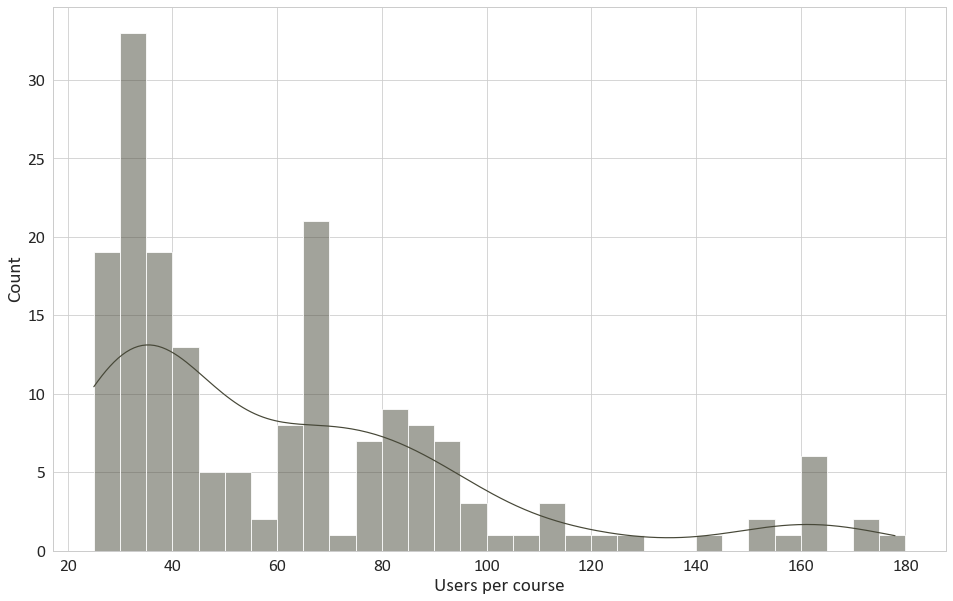

In [15]:
#then we plot an histogram with all courses, we are not interested in keeping courses with a number of students inferior to 10
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(16, 10)}, font_scale=2)
hist4 = sns.histplot(data=class_list, x='Users per course', kde=True, color= student_color, binwidth = 5,)

fig = hist4.get_figure()
fig.savefig('../Images/Nova_students_per_course_bin_5, filtered.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, hist4


Likewise, there is some attention to be found on courses with abnormally high numbers of attending students in a face-to-face context (over 200). We will pay closer attention to those courses.

In [16]:
#create df only with high affluence courses
most_affluent_courses = class_list[class_list['Users per course'] >= 100]

#separate logs accordingly
high_attendance_logs = student_logs[student_logs['courseid'].isin(most_affluent_courses['courseid']) & 
                            student_logs['cd_curso'].isin(most_affluent_courses['cd_curso']) &
                            student_logs['semestre'].isin(most_affluent_courses['semestre'])].reset_index(drop = True)
high_attendance_logs

,cd_curso,semestre,courseid,component,action,target,objecttable,userid,time,CourseFullname,nm_curso_pt,ds_discip_pt
0,9434.0,S1,200165.0,core,viewed,course,NaN,5916.0,2020-09-04 20:45:00,202021 - MÃ©todos Descritivos de Data Mining -...,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
1,9434.0,S1,200165.0,core,viewed,user_profile,user,5916.0,2020-09-04 20:45:00,202021 - MÃ©todos Descritivos de Data Mining -...,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
2,9434.0,S1,200165.0,mod_forum,viewed,course_module,forum,5916.0,2020-09-04 20:45:00,202021 - MÃ©todos Descritivos de Data Mining -...,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
3,9434.0,S1,200165.0,core,viewed,course,NaN,5916.0,2020-09-04 21:03:00,202021 - MÃ©todos Descritivos de Data Mining -...,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
4,9434.0,S1,200165.0,core,viewed,user_list,course,5916.0,2020-09-04 21:03:00,202021 - MÃ©todos Descritivos de Data Mining -...,Mestrado em Gestão de Informação,Métodos Descritivos de Data Mining
...,...,...,...,...,...,...,...,...,...,...,...,...
866758,9434.0,T4,200194.0,gradereport_user,viewed,grade_report,NaN,6155.0,2021-06-07 20:47:00,202021 - TransformaÃ§Ã£o Digital - Turma TP2 - T4,Mestrado em Gestão de Informação,Transformação Digital
866759,9434.0,T4,200194.0,core,viewed,course,NaN,6155.0,2021-06-07 21:00:00,202021 - TransformaÃ§Ã£o Digital - Turma TP2 - T4,Mestrado em Gestão de Informação,Transformação Digital
866760,7512.0,S2,200167.0,core,viewed,course,NaN,5755.0,2021-05-04 09:38:00,Big Data Analytics (MAA),Mestrado em Métodos Analíticos Avançados,Big Data Analytics
866761,7512.0,T4,200207.0,core,viewed,course,NaN,5755.0,2021-05-04 09:39:00,Big Data Modelling and Management,Mestrado em Métodos Analíticos Avançados,Modelação e Gestão de Big Data


In [17]:
high_attendance_logs.describe(include = 'all', datetime_is_numeric = 'all')

,cd_curso,semestre,courseid,component,action,target,objecttable,userid,time,CourseFullname,nm_curso_pt,ds_discip_pt
count,866763.0,866763,866763.0,866763,866763,866763,519329,866763.0,866763,866763,866763,866763
unique,2.0,6,21.0,17,19,35,28,580.0,NaN,36,2,21
top,9434.0,S1,200179.0,core,viewed,course,quiz_attempts,5730.0,NaN,202021 - Aprendizagem AutomÃ¡tica - S1,Mestrado em Gestão de Informação,Aprendizagem Automática
freq,500646.0,425338,74380.0,335450,811176,321099,147137,7602.0,NaN,74380,500646,74380
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-28 19:09:24.012030720,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-31 00:14:00,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-19 14:29:30,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-27 09:53:00,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-16 08:16:00,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-24 23:58:00,NaN,NaN,NaN


We can plot the weekly interactions of these courses.

In [18]:
#Then, when it comes to logs, we aggregate by week
grouped_data = high_attendance_logs.groupby([pd.Grouper(key='time', freq='W'), 'cd_curso', 'semestre', 'courseid']).agg({
                                                                             'action': 'count',
                                                                             }).reset_index().sort_values('time')

#change for better reading
grouped_data['Date (week)'] = grouped_data['time'].astype(str)

#creating pivot table to create heatmap
grouped_data = grouped_data.pivot_table(index =['cd_curso', 'semestre', 'courseid'], 
                       columns = 'Date (week)',
                        values = 'action', 
                       aggfunc =np.sum,
                        fill_value=np.nan)

#now, we will sort the courses according to the starting date
grouped_data = grouped_data.reset_index().rename(columns = {'courseid': 'Course',
                                                            'cd_curso': 'Program',
                                                            'semestre': 'Semester',
                                                           })

grouped_data['Course'] = pd.to_numeric(grouped_data['Course']).astype(int)

#finally we create the pivot_table that we will use to create our heatmap
grouped_data = grouped_data.set_index(['Program', 'Semester', 'Course'], drop = True)
grouped_data.T.describe(include = 'all').T

count         mean          std    min      25%  \
Program Semester Course                                                    
7512.0  S1       200175   21.0  2709.238095  2519.077309  123.0  1610.00   
                 200178   21.0  2901.238095  5285.832573  112.0   947.00   
                 200179   21.0  3541.904762  4453.726001  182.0  1692.00   
        S2       200167   21.0  1264.666667   941.554318   85.0   398.00   
        T1       200211   10.0  6105.800000  2627.512715  760.0  5415.25   
        T2       200174   13.0  1873.461538  1064.711590   96.0  1464.00   
        T3       200176   10.0  2628.500000  1190.419744  702.0  2266.50   
                 200194   10.0   758.500000   569.638531   97.0   331.00   
        T4       200207   10.0  2807.600000  1119.328092  769.0  2378.50   
9434.0  S1       200012   21.0  2670.333333  2834.012038  255.0  1264.00   
                 200071   21.0  1826.428571  1579.253291   29.0   374.00   
                 200165   21.0  3479.047619  6692.969337  439.0  1532.00   
                 200187   21.0  1248.809524  1149.061383   83.0   203.00   
                 200196   21.0  1877.190476  5088.146565   68.0   505.00   
        S2       200013   21.0  1446.571429  1480.197303   79.0   647.00   
                 200166   21.0  2127.666667  3868.380505  163.0  1093.00   
                 200167   21.0  1668.714286  1491.529321   15.0   935.00   
                 200170   21.0   411.285714   345.219661    9.0   162.00   
        T1       200073   10.0  1641.100000   909.903102  213.0  1186.25   
                 200192   10.0  2833.100000  3779.302389  398.0   982.50   
                 200193   10.0  3912.500000  3830.773384  354.0  1823.50   
        T2       200197   13.0  2903.769231  4170.412812   75.0  1194.00   
        T4       200194   10.0  2715.300000  3634.006361  116.0   485.25   

                            50%      75%      max  
Program Semester Course                            
7512.0  S1       200175  2079.0  2776.00  12639.0  
                 200178  1403.0  2467.00  24598.0  
                 200179  2298.0  2880.00  20693.0  
        S2       200167  1375.0  1839.00   3119.0  
        T1       200211  6099.0  8216.75   9200.0  
        T2       200174  2073.0  2674.00   3098.0  
        T3       200176  2513.5  2764.75   5018.0  
                 200194   610.0   966.50   1701.0  
        T4       200207  2838.5  3688.00   4342.0  
9434.0  S1       200012  1720.0  2873.00  13422.0  
                 200071  1792.0  3187.00   4666.0  
                 200165  1825.0  2538.00  32235.0  
                 200187   766.0  2258.00   3595.0  
                 200196   775.0  1010.00  23983.0  
        S2       200013  1140.0  1514.00   6769.0  
                 200166  1423.0  1593.00  18837.0  
                 200167  1206.0  1818.00   5527.0  
                 200170   315.0   513.00   1227.0  
        T1       200073  1677.5  1933.25   3632.0  
                 200192  1829.5  2770.50  13280.0  
                 200193  2952.0  3832.75  12953.0  
        T2       200197  2152.0  2550.00  16354.0  
        T4       200194   772.0  4028.75  11671.0

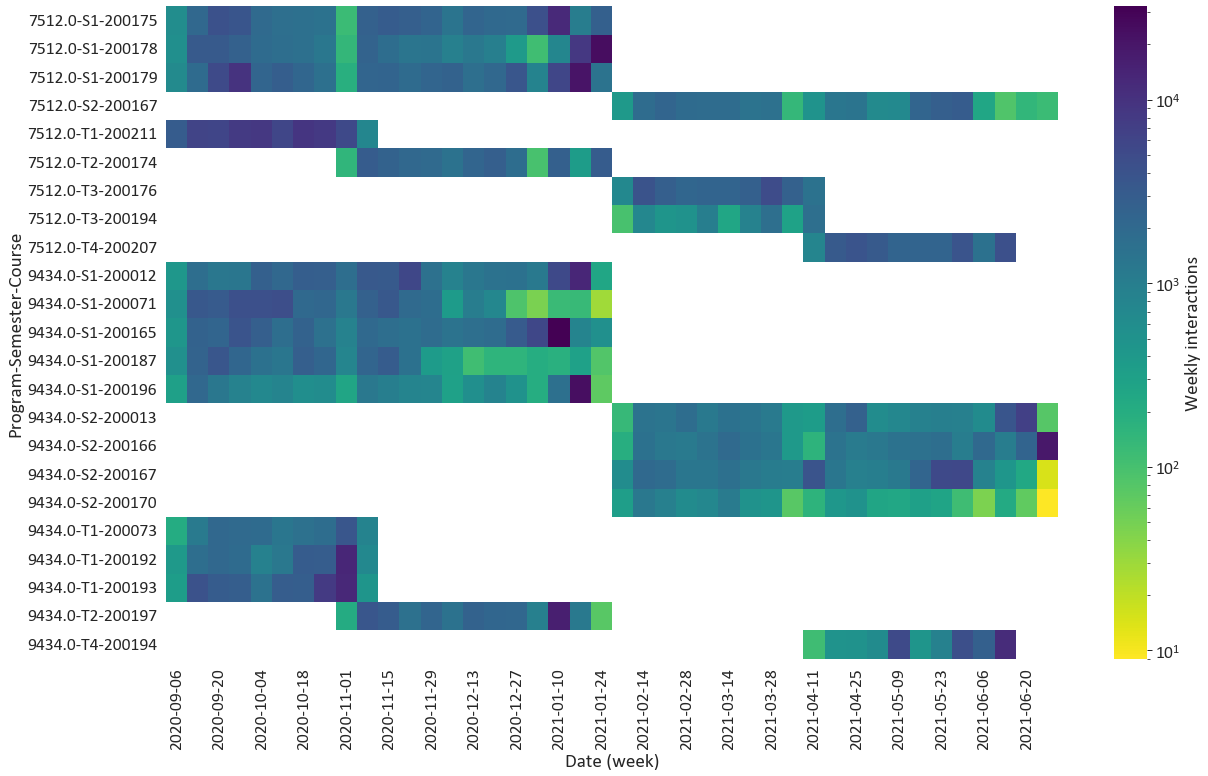

In [19]:
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(20, 12)}, font_scale=2)

#here, we are plotting the nex
heat4 = sns.heatmap(grouped_data, robust=True, norm=LogNorm(), xticklabels = 2, yticklabels= 1,
            cmap = standard_cmap, cbar_kws={'label': 'Weekly interactions'})

fig = heat4.get_figure()
fig.savefig('../Images/Nova_IMS_highest_attendance_weekly_clicks_heat.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, heat4

After consideration, we find that the student interactions seem to be consistent with the course duration. 

**1. First, we filter by our current list of valid courses.**

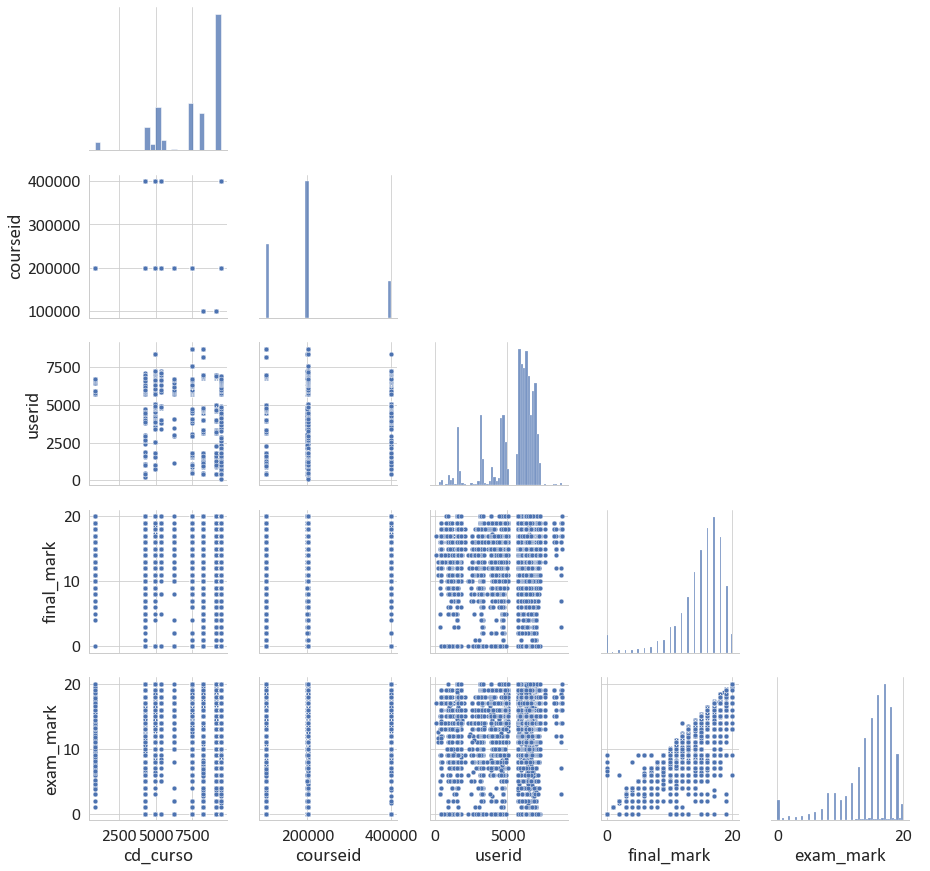

In [20]:
#Representation of different targets depending 
g = sns.PairGrid(targets_table, diag_sharey=False, corner=True)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.add_legend()

In [21]:
#a larger overlook at the different courses
targets_table.groupby(['cd_curso', 'semestre', 'courseid']).agg({
                                    'userid' : 'count', 
                                    'exam_mark' : ['min', 'mean', 'max'],                                    
                                    'final_mark' : ['min', 'mean', 'max'],
                                    }).describe(include = 'all')

userid   exam_mark                          final_mark              \
            count         min        mean         max         min        mean   
count  324.000000  324.000000  324.000000  324.000000  324.000000  324.000000   
mean    38.336420    8.030247   14.310546   17.644259    8.432099   14.636504   
std     40.180873    5.968975    2.950194    2.900330    5.957410    2.798434   
min      1.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      5.750000    1.000000   13.135233   17.000000    2.000000   13.599038   
50%     30.000000    9.000000   14.641711   18.000000   10.000000   15.130252   
75%     64.000000   13.000000   16.333333   19.000000   13.250000   16.475455   
max    179.000000   19.000000   19.333333   20.000000   19.000000   19.333333   

                   
              max  
count  324.000000  
mean    17.706790  
std      2.857365  
min      0.000000  
25%     17.000000  
50%     18.000000  
75%     19.000000  
max     20.000000

**We will finish by taking a look at our support table**. This table associates all students attending a specific course and the partial grades obtained by each student.

In the Nova IMS these grades are not timestamped (i.e. we do not know to which assignment-quizz-event the partial grade refers to nor when the specific assignment refers to).

In [22]:
#get info
support_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34266 entries, 0 to 34265
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   cd_curso         34266 non-null  object        
 1   semestre         34266 non-null  object        
 2   courseid         34266 non-null  object        
 3   statusAvaliacao  32301 non-null  object        
 4   userid           34266 non-null  object        
 5   assignment_mark  32301 non-null  float64       
 6   assign_id        32301 non-null  object        
 7   nm_curso_pt      34266 non-null  object        
 8   ds_discip_pt     34266 non-null  object        
 9   end_date         34266 non-null  datetime64[ns]
 10  startdate        34266 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(8)
memory usage: 2.9+ MB


In [23]:
support_table.describe(include = 'all', datetime_is_numeric = True)

,cd_curso,semestre,courseid,statusAvaliacao,userid,assignment_mark,assign_id,nm_curso_pt,ds_discip_pt,end_date,startdate
count,34266.0,34266,34266.0,32301,34266.0,32301.000000,32301.0,34266,34266,34266,34266
unique,15.0,6,146.0,13,1752.0,NaN,946.0,15,139,NaN,NaN
top,9155.0,S1,200071.0,Nota Parcial 1,4675.0,NaN,1552.0,Licenciatura em Gestão de Informação,Gestão do Conhecimento,NaN,NaN
freq,7696.0,14114,1426.0,9715,55.0,NaN,179.0,7696,1426,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,14.448662,NaN,NaN,NaN,2021-03-30 22:05:39.135002624,2020-11-27 09:13:45.144457984
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,2020-11-06 00:00:00,2020-09-07 00:00:00
25%,NaN,NaN,NaN,NaN,NaN,12.500000,NaN,NaN,NaN,2021-01-22 00:00:00,2020-09-07 00:00:00
50%,NaN,NaN,NaN,NaN,NaN,15.800000,NaN,NaN,NaN,2021-01-22 00:00:00,2020-11-02 00:00:00
75%,NaN,NaN,NaN,NaN,NaN,17.730000,NaN,NaN,NaN,2021-06-25 00:00:00,2021-02-08 00:00:00
max,NaN,NaN,NaN,NaN,NaN,20.000000,NaN,NaN,NaN,2021-06-25 00:00:00,2021-04-12 00:00:00


In [24]:
support_table

,cd_curso,semestre,courseid,statusAvaliacao,userid,assignment_mark,assign_id,nm_curso_pt,ds_discip_pt,end_date,startdate
0,8259.0,S1,100001.0,NaN,1544.0,NaN,NaN,Licenciatura em Sistemas e Tecnologias de Info...,Álgebra Linear,2021-01-22,2020-09-07
1,8259.0,S1,100001.0,Nota Parcial 1,1556.0,13.9,0.0,Licenciatura em Sistemas e Tecnologias de Info...,Álgebra Linear,2021-01-22,2020-09-07
2,8259.0,S1,100001.0,Nota Parcial 2,1556.0,8.7,1.0,Licenciatura em Sistemas e Tecnologias de Info...,Álgebra Linear,2021-01-22,2020-09-07
3,9155.0,S1,100001.0,Nota Parcial 1,1564.0,16.8,2.0,Licenciatura em Gestão de Informação,Álgebra Linear,2021-01-22,2020-09-07
4,9155.0,S1,100001.0,Nota Parcial 2,1564.0,7.3,3.0,Licenciatura em Gestão de Informação,Álgebra Linear,2021-01-22,2020-09-07
...,...,...,...,...,...,...,...,...,...,...,...
34261,4969.0,T4,400094.0,Nota Parcial 5,7248.0,12.7,1789.0,Pós-Graduação em Digital Enterprise Management,Big Data Analytics for Business,2021-06-11,2021-04-12
34262,4969.0,T4,400094.0,Nota Parcial 2,7250.0,17.0,1786.0,Pós-Graduação em Digital Enterprise Management,Big Data Analytics for Business,2021-06-11,2021-04-12
34263,4969.0,T4,400094.0,Nota Parcial 3,7250.0,18.0,1787.0,Pós-Graduação em Digital Enterprise Management,Big Data Analytics for Business,2021-06-11,2021-04-12
34264,4969.0,T4,400094.0,Nota Parcial 4,7250.0,17.0,1788.0,Pós-Graduação em Digital Enterprise Management,Big Data Analytics for Business,2021-06-11,2021-04-12


In [25]:
#a larger overlook at the different courses
support_table.groupby(['cd_curso', 'semestre', 'courseid']).agg({
                                    'userid' : 'nunique',
                                    'assign_id' : 'nunique', 
#                                     'mandatory_status' : 'mean',
#                                     'delivered' : 'mean',                                    
                                    'assignment_mark' : 'mean',
                                    }).describe(include = 'all')

,userid,assign_id,assignment_mark
count,324.000000,324.000000,265.000000
mean,38.336420,2.919753,14.408618
std,40.180873,2.160663,2.375078
min,1.000000,0.000000,1.750000
25%,5.750000,2.000000,13.289541
50%,30.000000,3.000000,14.735484
75%,64.000000,4.000000,16.104167
max,179.000000,11.000000,19.000000


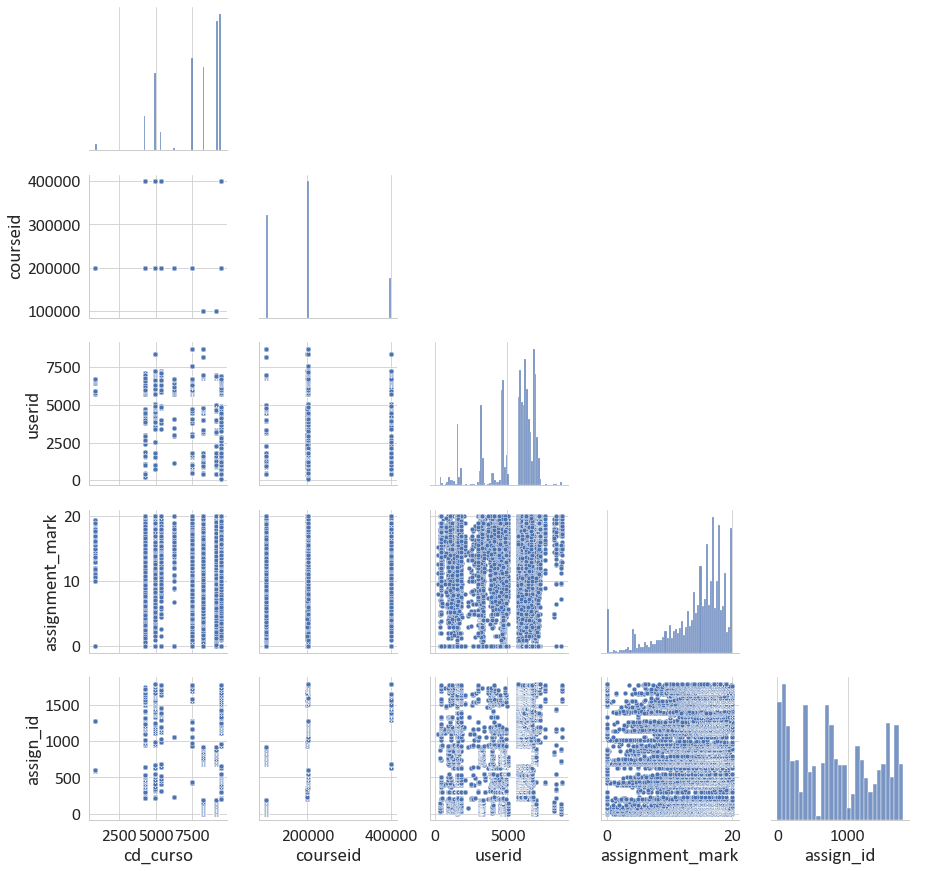

In [26]:
#Representation of different targets depending 
g = sns.PairGrid(support_table, diag_sharey=False, corner=True)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.add_legend()

**Going forward**.

After this preliminary look, we will go forward with extracting features from the Moodle logs. 

In this notebook, we will consider a temporal representation that considers each student-course pair as a row and each column to represent a day in the course.

An important distinction is that, when working in this manner, we do not have to perform multiple pre-processing steps. Instead we get, for each row, a sequence of the daily number of clicks.

For the purposes of retaining the same sets of rows as the ones we got previously we will follow through with the preprocessing steps we had determined in the non-temporal representation. Again, this is exclusively performed to retain the same rows we had previously.

In [27]:
#correct objecttable
other_objects =  ['tag_instance', 'badge', 'feedback_completed', 'feedback', 'course_modules_completion', 'feedback',
                 'workshop_submissions', 'workshop', "bigbluebuttonbn"]

#badges on target id
badges_on_target = ['badge_listing', 'badge', 'recent_activity']

#grades 
grading_objects = ['gradereport_overview', 'gradereport_user']

#assignment from elements in the component column
assign_objects = ['assignsubmission_onlinetext', 'assignsubmission_comments', 'mod_assign', 'assignsubmission_file']

#books to resource
books = ["book_chapters", "book"]

#course
courses_on_target = ['course', 'course_resources_list', 'course_user_report']

#corrections on the objecttable column
student_logs['objecttable'] = np.where(student_logs['objecttable'].isin(other_objects),
                                      'other',
                                       np.where(student_logs['target'].isin(badges_on_target),
                                      'other',
                                       np.where(student_logs['target'].isin(courses_on_target),
                                      'course',
                                      np.where(student_logs['component'] == 'mod_forum',
                                      'forum',
                                      np.where(student_logs['component'].isin(grading_objects),
                                      'grade_grades',
                                       np.where(student_logs['component'].isin(assign_objects),
                                      'assignments',
                                       np.where(student_logs['objecttable'].isin(books),
                                      'resource',
                                       np.where(student_logs['component'] == 'mod_coice',
                                      'choice',
                                       np.where(student_logs['component'] == 'mod_choicegroup',
                                      'groups',
                                       np.where((student_logs['component'] == 'mod_quiz') & (student_logs['objecttable'].isna()),
                                      'quiz',
                                       np.where((student_logs['objecttable'] == 'choice_answers'),
                                      'choice',
                                       np.where((student_logs['objecttable'] == 'quiz_attempts'),
                                      'quiz',
                                       np.where((student_logs['objecttable'] == 'quiz_attempts'),
                                      'quiz',   
                                      student_logs['objecttable']
                                        )))))))))))))

del other_objects, badges_on_target, grading_objects, assign_objects, books, courses_on_target

In [28]:
# #uncomment to verify pairings
# with pd.option_context('display.max_rows', None,):
#      display(student_logs['objecttable'].value_counts())

In [29]:
# #uncomment to verify pairings
# with pd.option_context('display.max_rows', None,):
#      display(student_logs['component'].value_counts())

In [30]:
# #uncomment to verify pairings
# with pd.option_context('display.max_rows', None,):
#      display(student_logs['target'].value_counts())

In [31]:
# #uncomment to verify pairings
# with pd.option_context('display.max_rows', None,):
#      display(student_logs['action'].value_counts())

Likewise, we will need to take a look at the different actions in order to understand how common these may be. 

Again, we will look at different actions and see how we can group them together in a way that, at least, makes intuitive sense. There is use in keeping the distinction between different types of view.

In [32]:
#updates and edits related to making editions on presented information:

#additions 
addition = ['created', 'added']

#deletion
deletion = ['deleted', 'removed']

#other actions
other_actions = ['awarded', 'printed', 'abandoned', 'searched']

#submissions
submission = ['submitted', 'submission', 'submissions']

#converts discussion points to forum or, alternatively,groups other elements to other category
student_logs['action'] = np.where(student_logs['action'].isin(addition), 'added', #addition list
                                  np.where(student_logs['action'].isin(deletion), 'delete', #deletion list
                                  np.where(student_logs['action'].isin(other_actions), 'other actions', #other actions
                                  np.where(student_logs['action'].isin(submission), 'submission', #submissions to submission
                                  student_logs['action']
                                 ))))

#we finish by ending these lists we've created
del addition, deletion, other_actions, submission

In [33]:
# # #uncomment to verify pairings
# with pd.option_context('display.max_rows', None,):
#      display(student_logs.groupby(['objecttable', 'target', 'action']).size().to_frame())

We do not know, yet, whether we can make an effective association between the partial grades and the logs. We can explore the submissions made in each discipline and calculate the likely dates of submission.

For that, for every course, we will look at submissions performed by the different students.

We will count the number of assignments assigned to each discipline - the number of graded assignments givenaverage number of grades attributed in each curricular unit.

In [34]:
#then we get all unique entries and assign them an index number
courses = class_list[['cd_curso', 'semestre', 'courseid']].drop_duplicates().reset_index(drop = True).reset_index()

#then, we create a dict using the combination of index, courseid and status as keys
courses = courses.set_index(['cd_curso', 'semestre', 'courseid']).to_dict()['index']

#set index of df to match same index
class_list.set_index(['cd_curso', 'semestre', 'courseid'], drop = True, inplace = True)

#set index of df to match same index
student_logs.set_index(['cd_curso', 'semestre', 'courseid'], drop = True, inplace = True)

#set index of support_df to match same index
support_table.set_index(['cd_curso', 'semestre', 'courseid'], drop = True, inplace = True)

#set index of targets_table to match same index
targets_table.set_index(['cd_curso', 'semestre', 'courseid'], drop = True, inplace = True)

#use index as key for dict
student_logs['course_encoding'] = student_logs.index.map(courses).astype(object)
class_list['course_encoding'] = class_list.index.map(courses).astype(object)
support_table['course_encoding'] = support_table.index.map(courses).astype(object)
targets_table['course_encoding'] = targets_table.index.map(courses).astype(object)

#resetting index
student_logs = student_logs.dropna(subset = ['course_encoding']).reset_index()
class_list.reset_index(inplace = True)
support_table = support_table.dropna(subset = ['course_encoding']).reset_index()
targets_table = targets_table.dropna(subset = ['course_encoding']).reset_index()

In [35]:
#first, get count of assignments as defined in the support_table 
assignments_per_course = support_table.groupby('course_encoding').agg({'assign_id' : 'nunique'})
assignments_per_course = assignments_per_course.to_dict()['assign_id']

#next, we filter by only keepting submissions, avoid the first 2 weeks of submissions
submission_logs = student_logs[(student_logs['action'] == 'submission') & (student_logs['time'] >= '2020-09-18')].sort_values(by = 'time').reset_index(drop = True)

In [36]:
#second filtering condition - keep add, assessable and attempts -> edits and deletes are not relevant to determine number of submissions
submission_logs = submission_logs[submission_logs['target'].isin(target_to_keep := ['add',
                                                                                    'assessable',
                                                                                    'attempt',
                                                                                   ])]
#add number of assignments of submission_logs
submission_logs['nbr_assignments'] = submission_logs['course_encoding'].map(assignments_per_course)

#we give each submission made by each student in the context of certain curricular units
submission_logs['course_student_submission_number'] = submission_logs.groupby(['course_encoding', 'userid']).cumcount() + 1
submission_logs = submission_logs.filter(['course_encoding', 'userid', 'time', 'course_student_submission_number', 'nbr_assignments'])

#then, we get the number of submissions made by each student and the average date for each submission
submission_logs = submission_logs.groupby(['course_encoding', 'course_student_submission_number']).agg(
                                                                                {
                                                                                    'userid': 'count',
                                                                                    'time': ['mean', 'median'],
                                                                                    'nbr_assignments': 'mean' #equal to same 
                                                                                })

#applies the function that removes multiindex
submission_logs.columns = submission_logs.columns.map(flattenHierarchicalCol)
submission_logs.reset_index(inplace = True)

#then, we only keep the number of submissions that is in line with the number on the support_table
submission_logs = submission_logs[submission_logs['course_student_submission_number'] <= submission_logs['nbr_assignments_mean']].reset_index(drop = True)
submission_logs['course_student_submission_number'] = submission_logs['course_student_submission_number'].astype(object)
submission_logs['course_encoding'] = submission_logs['course_encoding'].astype(object)

#then, in order to make the proper merge, we'll need to make the proper adjustments - namely label the submission date of each discipline
support_table['course_student_submission_number'] = pd.to_numeric(support_table['statusAvaliacao'].str.extract('(\d+)', expand=False)).astype(object)

In this next step we, we will timestamp each assignment recorded on the support table. It is likely that, in group assigments, only one student submits for all coleagues. Therefore, it is not possible to make a 1 to 1 between submission and grade.

In general -> Partial grade 1 refers to a student's first submission, partial grade 2 to the second submission, etc...
We will assume deadline date for each partial grade to be the median delivery date of the classe's ith submission.

In [37]:
#filtering columns before merge
submission_logs = submission_logs.filter(['course_encoding', 'course_student_submission_number',
                                         'time_median'])

#making a rightward merge with the support_table on course_encoding and course_student_submission_number
support_table = pd.merge(support_table, submission_logs, on = ['course_encoding', 'course_student_submission_number'], how = 'left')

#at this stage, we can now start dropping columns that are ultimately unnecessary and reclaibrating the assign_id column
support_table['assign_id'] = support_table.groupby(['course_encoding', 'statusAvaliacao']).ngroup()
support_table['sup_time'] = pd.to_datetime(support_table['time_median'].dt.date)
support_table.drop(['statusAvaliacao', 'course_student_submission_number', 'time_median'], axis = 1, inplace = True)

del submission_logs, assignments_per_course

support_table.describe(include = 'all', datetime_is_numeric = True)

,cd_curso,semestre,courseid,userid,assignment_mark,assign_id,nm_curso_pt,ds_discip_pt,end_date,startdate,course_encoding,sup_time
count,31618.000000,31618,31618.000000,31618.0,29825.000000,31618.000000,31618,31618,31618,31618,31618.0,22697
unique,NaN,6,NaN,1713.0,NaN,NaN,15,139,NaN,NaN,181.0,NaN
top,NaN,S1,NaN,4747.0,NaN,NaN,Licenciatura em Gestão de Informação,Gestão do Conhecimento,NaN,NaN,151.0,NaN
freq,NaN,13360,NaN,53.0,NaN,NaN,7379,1364,NaN,NaN,1017.0,NaN
mean,7852.463122,NaN,189628.093965,NaN,14.498990,279.827061,NaN,NaN,2021-03-29 11:04:31.668037376,2020-11-25 20:56:49.399709184,NaN,2021-03-03 20:15:35.806493952
min,859.000000,NaN,100001.000000,NaN,0.000000,-1.000000,NaN,NaN,2020-11-06 00:00:00,2020-09-07 00:00:00,NaN,2020-09-21 00:00:00
25%,7512.000000,NaN,100080.000000,NaN,12.600000,164.000000,NaN,NaN,2021-01-22 00:00:00,2020-09-07 00:00:00,NaN,2020-12-27 00:00:00
50%,8259.000000,NaN,200101.000000,NaN,15.850000,285.000000,NaN,NaN,2021-01-22 00:00:00,2020-11-02 00:00:00,NaN,2021-03-25 00:00:00
75%,9155.000000,NaN,200195.000000,NaN,17.750000,429.000000,NaN,NaN,2021-06-25 00:00:00,2021-02-08 00:00:00,NaN,2021-05-29 00:00:00
max,9435.000000,NaN,400131.000000,NaN,20.000000,536.000000,NaN,NaN,2021-06-25 00:00:00,2021-04-12 00:00:00,NaN,2021-06-24 00:00:00


We have addressed the most obvious possible aggregations. Now, we will go forward with our intended feature extraction and selection.

We can start by removing all of the unnecessary columns that we will not be using going forward and, then, create 5 distinct dicts of dataframes. Each dict refers to a certain course duration threshold.

In [38]:
#filtering for 
student_logs = student_logs.filter(['cd_curso', 'semestre', 'courseid', 'objecttable', 'action', 'target', 'component',
                                   'userid', 'time', 'course_encoding'])

In [39]:
student_logs

,cd_curso,semestre,courseid,objecttable,action,target,component,userid,time,course_encoding
0,9434.0,S1,200165.0,course,viewed,course,core,5916.0,2020-09-04 20:45:00,152.0
1,9434.0,S1,200165.0,user,viewed,user_profile,core,5916.0,2020-09-04 20:45:00,152.0
2,9434.0,S1,200165.0,forum,viewed,course_module,mod_forum,5916.0,2020-09-04 20:45:00,152.0
3,9434.0,S1,200165.0,course,viewed,course,core,5916.0,2020-09-04 21:03:00,152.0
4,9434.0,S1,200165.0,course,viewed,user_list,core,5916.0,2020-09-04 21:03:00,152.0
...,...,...,...,...,...,...,...,...,...,...
2915765,4974.0,S2,400106.0,course,viewed,course,core,6512.0,2021-06-24 19:45:00,49.0
2915766,9434.0,S2,200167.0,course,viewed,course,core,4118.0,2021-06-13 09:36:00,162.0
2915767,4955.0,S2,200013.0,course,viewed,course,core,6029.0,2021-06-16 18:31:00,20.0
2915768,4955.0,S2,200013.0,course,viewed,course,core,6029.0,2021-06-17 18:14:00,20.0


In [40]:
#additionally, we will look at our estimated course duration
for i in tqdm(duration_threshold):
    #create, for each desired threshold, the appropriate cutoff date 
    class_list[f'Date_threshold_{int(i*100)}'] = pd.to_datetime((class_list['Start Date'] + pd.to_timedelta(class_list['Course duration days'] * i, unit = 'Days')).dt.date)
    
        #setting up duration threshold to be on friday -> reason being that it will be easier to 
    class_list[f'Date_threshold_{int(i*100)}'] = class_list[f'Date_threshold_{int(i*100)}'].where( class_list[f'Date_threshold_{int(i*100)}'] == (( class_list[f'Date_threshold_{int(i*100)}'] + Week(weekday=4)) - Week()), class_list[f'Date_threshold_{int(i*100)}'] + Week(weekday=4))

#then, we will create a dictionary of dictionaries, each main dictionary storing and a version of the logs
logs_dict = {}

for i in tqdm(duration_threshold):
    #create, for each desired threshold, a different dictionary of dataframes wherein we will perform the different operations
    print(f'Date_threshold_{int(i*100)}\n' +
          f'Logs')
    logs_dict[f'Date_threshold_{int(i*100)}'] = {course: student_logs.loc[student_logs['course_encoding'] == course].reset_index(drop = True) for course in tqdm(student_logs['course_encoding'].unique())}

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Date_threshold_10
Logs


  0%|          | 0/181 [00:00<?, ?it/s]

Date_threshold_25
Logs


  0%|          | 0/181 [00:00<?, ?it/s]

Date_threshold_33
Logs


  0%|          | 0/181 [00:00<?, ?it/s]

Date_threshold_50
Logs


  0%|          | 0/181 [00:00<?, ?it/s]

Date_threshold_100
Logs


  0%|          | 0/181 [00:00<?, ?it/s]

In [41]:
#create backup of logs dict, we will need it for later
backup = deepcopy(logs_dict)

In [42]:
#create backup of logs dict, we will need it for later
logs_dict = deepcopy(backup)

In [43]:
#for each intended course duration threshold
for i in tqdm(logs_dict):
    #start with creating a dictionary of course and intended cuttoff date
    cut = class_list.set_index('course_encoding').to_dict()[i] 
    
    #for each dataframe
    for j in tqdm(logs_dict[i]):
        #where the course is the same as in the class_list, get the corresponding value of the appropriate column,
        logs_dict[i][j]['Date Threshold'] = logs_dict[i][j]['course_encoding'].map(cut)
        logs_dict[i][j] = logs_dict[i][j][logs_dict[i][j]['time'] <= logs_dict[i][j]['Date Threshold']].reset_index(drop = True).drop('Date Threshold', axis = 1)

        #Aggregate by day
        logs_dict[i][j] = logs_dict[i][j].groupby(['course_encoding', 'cd_curso', 'semestre', 'courseid', pd.Grouper(key='time', freq='D'), 'userid', 'objecttable']).agg({
                                                                                                                'action': 'count', 
                                                                                                                }).reset_index().sort_values('time')
        
        #then, we create a pivot_table
        logs_dict[i][j] = pd.pivot_table(logs_dict[i][j], index=['course_encoding', 'cd_curso', 'semestre', 'courseid', 'userid', 'objecttable'], columns = 'time', values = 'action',
                    aggfunc='sum').fillna(0)
        
        #and rename columns to fit with the number of days
        logs_dict[i][j] = logs_dict[i][j].rename(columns={x:y for x,y in zip(logs_dict[i][j].columns,range(1,len(logs_dict[i][j].columns) + 1))})
        logs_dict[i][j].columns.name = None
        logs_dict[i][j].reset_index(inplace = True)
        
        #joining final grade for target
        logs_dict[i][j] = pd.merge(logs_dict[i][j], targets_table.filter(['course_encoding', 'userid', 'exam_mark', 'final_mark']), on = ['course_encoding', 'userid'], how = 'right')
        
    #after the end of the loops:
    logs_dict[i] = pd.concat(logs_dict[i], ignore_index=True)
    logs_dict[i] = logs_dict[i].sort_values(by = ['course_encoding', 'userid', 'objecttable', 'final_mark']).reset_index(drop = True)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

Now, we have a nested dictionary with different dataframes inside it. We will use this data structure to perform the most of the operations we are interested in.

**First, we will add, to each dataframe, a column with the corresponding threshold date**

After this cleaning procedure, we will, for each course get the daily clicks and put them on a pivot_table. We will finish the procedure by exporting updated versions of the class list as these will also need to be used going forward.

In order to account for situations where registered students only access Moodle later in the course, we will make an additional, but necessary adaptation. 

We will start by looking at the complete set of valid students/courses in our 100% dataset. From these, we get the indexes of the rows that are valid (i.e. have a valid click count at 100% duration), get the indexes and retain only these.

In [44]:
#then slice accordingly - selecting all keys except the manually programmed one
for i in tqdm(list(logs_dict.keys())):
    rows_to_keep = logs_dict[i][~logs_dict[i][1].isna()].index
    logs_dict[i] = logs_dict[i].iloc[rows_to_keep, :].reset_index(drop = True)

  0%|          | 0/5 [00:00<?, ?it/s]

In [45]:
#set index columns
ind_cols = ['course_encoding', 'cd_curso', 'semestre', 'courseid', 'userid', 'objecttable', 'exam_mark', 'final_mark']

#create reference for all existing real combinations
logs_dict['Date_threshold_100'].set_index(ind_cols, inplace = True)

In [46]:
#copy on all other dfs
for i in tqdm(list(logs_dict.keys())[:-1]):
    
    #set index and reindex according to multiindex
    logs_dict[i].set_index(ind_cols, inplace = True)
    logs_dict[i] = logs_dict[i].reindex(logs_dict['Date_threshold_100'].index)

  0%|          | 0/4 [00:00<?, ?it/s]

#### Almost Done.

We will finish this step momentarily. Before we do, we need to save all dfs in an easily accessible Excel File.

In [47]:
writer = pd.ExcelWriter('../Data/Modeling Stage/Nova_IMS_Temporal_Datasets_daily_clicks.xlsx', engine='xlsxwriter')

#now loop thru and put each on a specific sheet
for sheet, frame in  logs_dict.items(): 
    frame.reset_index().to_excel(writer, sheet_name = sheet)

#critical last step
writer.save()

#also saving additional info on class list
class_list.to_csv('../Data/Modeling Stage/Nova_IMS_updated_classlist.csv')